In [1]:
"""
MATRIX FACTORIZATION FOR RECOMMENDATION SYSTEMS WITH ENHANCED FEATURES

This implementation addresses the following exercise requirements:

TASK 1: Implement the Alternating Least Squares (ALS) Algorithm
- Complete the fit_als method by implementing ALS that alternates between
  fixing item factors to solve for user factors and vice versa
- The algorithm minimizes the objective function with regularization
- Uses linear algebra to solve the normal equations at each step

TASK 2: Implement Recommendation Generation
- Complete the get_user_recommendations method to generate personalized
  recommendations based on predicted ratings
- Predict ratings for unrated items and return top-N recommendations

BONUS FEATURES IMPLEMENTED:
1. Experiment with different numbers of latent factors (5, 10, 20, 50)
2. Early stopping based on validation error to avoid overfitting
3. Visualize learned latent factors using PCA/t-SNE
4. Enhanced recommendation generation with diversity options

MATHEMATICAL FOUNDATION:
Matrix factorization approximates the rating matrix R as:
R ≈ P·Q^T
Where:
- P ∈ R^(|U|×k) is the user latent factor matrix
- Q ∈ R^(|I|×k) is the item latent factor matrix
- k is the number of latent factors

For user u and item i, predicted rating is:
r̂_ui = μ + b_u + b_i + p_u · q_i^T

Where:
- μ is the global average rating
- b_u is the bias term for user u
- b_i is the bias term for item i
- p_u is the latent factor vector for user u
- q_i is the latent factor vector for item i
"""

'\nMATRIX FACTORIZATION FOR RECOMMENDATION SYSTEMS WITH ENHANCED FEATURES\n\nThis implementation addresses the following exercise requirements:\n\nTASK 1: Implement the Alternating Least Squares (ALS) Algorithm\n- Complete the fit_als method by implementing ALS that alternates between\n  fixing item factors to solve for user factors and vice versa\n- The algorithm minimizes the objective function with regularization\n- Uses linear algebra to solve the normal equations at each step\n\nTASK 2: Implement Recommendation Generation\n- Complete the get_user_recommendations method to generate personalized\n  recommendations based on predicted ratings\n- Predict ratings for unrated items and return top-N recommendations\n\nBONUS FEATURES IMPLEMENTED:\n1. Experiment with different numbers of latent factors (5, 10, 20, 50)\n2. Early stopping based on validation error to avoid overfitting\n3. Visualize learned latent factors using PCA/t-SNE\n4. Enhanced recommendation generation with diversity op

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings

# Suppress warning messages for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducible results across runs
np.random.seed(42)


In [ ]:
class MatrixFactorization:
    """
    Matrix Factorization Model for Collaborative Filtering using Alternating Least Squares (ALS)

    This class implements the core matrix factorization algorithm that learns latent factors
    for users and items to predict missing ratings in a user-item matrix.

    The model decomposes the rating matrix R into two lower-rank matrices:
    R ≈ P·Q^T where P contains user factors and Q contains item factors
    """

    def __init__(self, n_users, n_items, n_factors=20, regularization=0.1):
        """
        Initialize the matrix factorization model with random factor matrices and zero biases

        Parameters:
        -----------
        n_users : int
            Number of users in the dataset - determines the rows of user factor matrix
        n_items : int
            Number of items in the dataset - determines the rows of item factor matrix
        n_factors : int
            Number of latent factors (embedding dimension) - the hidden dimensionality
            that captures user preferences and item characteristics
        regularization : float
            Regularization parameter λ to prevent overfitting by penalizing large factor values
        """
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.regularization = regularization

        # Initialize user and item factor matrices with small random values from normal distribution
        # Small scale (0.1) prevents initial predictions from being too large
        self.user_factors = np.random.normal(scale=0.1, size=(n_users, n_factors))
        self.item_factors = np.random.normal(scale=0.1, size=(n_items, n_factors))

        # Initialize bias terms to zero - these will be learned during training
        # User bias captures how much a user tends to rate above/below average
        # Item bias captures how much an item is rated above/below average
        self.user_bias = np.zeros(n_users)
        self.item_bias = np.zeros(n_items)
        self.global_bias = 0.0  # Will be set to mean of all ratings

        # Variables for early stopping mechanism to prevent overfitting
        self.best_val_rmse = float('inf')  # Track best validation RMSE seen so far
        self.patience_counter = 0  # Count iterations without improvement
        self.best_factors = None  # Store best model state for restoration

    def predict(self, user_id, item_id):
        """
        Predict the rating that user_id would give to item_id using the learned factors

        This implements the core prediction formula:
        r̂_ui = μ + b_u + b_i + p_u · q_i^T

        Parameters:
        -----------
        user_id : int
            User identifier (0-based indexing)
        item_id : int
            Item identifier (0-based indexing)

        Returns:
        --------
        float
            Predicted rating for the user-item pair
        """
        # Handle out-of-bounds user/item IDs by returning global average
        # This provides a reasonable fallback for unseen users/items
        if user_id >= self.n_users or item_id >= self.n_items:
            return self.global_bias

        # Compute predicted rating using the matrix factorization formula
        # global_bias: overall average rating across all users and items
        # user_bias: how much this user deviates from average (generous vs critical)
        # item_bias: how much this item deviates from average (popular vs unpopular)
        # dot product: interaction between user preferences and item characteristics
        prediction = (
                self.global_bias
                + self.user_bias[user_id]
                + self.item_bias[item_id]
                + np.dot(self.user_factors[user_id], self.item_factors[item_id])
        )

        return prediction

    def fit_als(self, ratings, validation_data=None, n_iterations=20, early_stopping=True, patience=5):
        """
        TASK 1 SOLUTION: Train the model using Alternating Least Squares (ALS) algorithm

        ALS alternates between:
        1. Fixing item factors and solving for optimal user factors
        2. Fixing user factors and solving for optimal item factors

        Each step solves a regularized least squares problem using normal equations.

        For user factors: (Σ q_i·q_i^T + λI)·p_u = Σ q_i·(r_ui - μ - b_u - b_i)
        For item factors: (Σ p_u·p_u^T + λI)·q_i = Σ p_u·(r_ui - μ - b_u - b_i)

        Parameters:
        -----------
        ratings : DataFrame
            Training data containing columns: user_id, item_id, rating
        validation_data : DataFrame, optional
            Validation data for early stopping and monitoring generalization
        n_iterations : int
            Maximum number of ALS iterations to perform
        early_stopping : bool
            Whether to stop training early if validation RMSE stops improving
        patience : int
            Number of iterations to wait for improvement before stopping early

        Returns:
        --------
        tuple
            (train_errors, val_errors) - RMSE values for each iteration
        """
        # Extract user, item, and rating arrays from the DataFrame for efficient processing
        user_ids = ratings['user_id'].values
        item_ids = ratings['item_id'].values
        y = ratings['rating'].values

        # Set global bias as mean of all ratings - this centers the data
        # Helps with numerical stability and provides baseline prediction
        self.global_bias = np.mean(y)

        # Build efficient data structure: user -> {item: rating} dictionary
        # This allows fast lookup of all items rated by a user
        ui_dict = {}
        for u, i, r in zip(user_ids, item_ids, y):
            ui_dict.setdefault(u, {})[i] = r

        # Lists to store training and validation RMSE for each iteration
        train_errors = []  # Track training progress
        val_errors = []  # Track generalization performance
        best_val_rmse = float('inf')  # Best validation RMSE seen so far
        patience_counter = 0  # Iterations without improvement
        best_state = None  # Store best model parameters

        print(f"Starting training with {self.n_factors} factors, λ={self.regularization}")

        # Main ALS training loop - alternate between updating users and items
        for it in range(n_iterations):

            # === STEP 1: Fix item factors, solve for user factors ===
            for u in range(self.n_users):
                # Skip users with no ratings - nothing to learn from
                if u not in ui_dict or len(ui_dict[u]) == 0:
                    continue

                rated_items = ui_dict[u]  # Items rated by user u

                # Build normal equation matrices A·x = b for user factors
                A = np.zeros((self.n_factors, self.n_factors))  # Accumulate q_i·q_i^T
                b = np.zeros(self.n_factors)  # Accumulate target vector

                # For each item i rated by user u, add its contribution to normal equations
                for i, r_ui in rated_items.items():
                    q_i = self.item_factors[i]  # Item i's latent factors
                    A += np.outer(q_i, q_i)  # Add q_i·q_i^T to matrix A

                    # Target: rating minus all bias terms (isolate latent factor interaction)
                    target = r_ui - self.global_bias - self.item_bias[i] - self.user_bias[u]
                    b += target * q_i  # Add q_i·target to vector b

                # Add regularization: λI scaled by number of ratings for this user
                # More ratings = more evidence = can afford less regularization
                A += self.regularization * len(rated_items) * np.eye(self.n_factors)

                try:
                    # Solve normal equations: A·p_u = b for user factors p_u
                    self.user_factors[u] = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix (rare) by resetting to zero
                    self.user_factors[u] = np.zeros(self.n_factors)

                # === Update user bias with regularization ===
                # User bias captures systematic tendency to rate high/low
                numer = 0.0
                for i, r_ui in rated_items.items():
                    # Residual after removing global bias, item bias, and latent factors
                    residual = (r_ui - self.global_bias - self.item_bias[i] -
                                np.dot(self.user_factors[u], self.item_factors[i]))
                    numer += residual

                # Regularized bias update: shrink towards zero
                self.user_bias[u] = numer / (self.regularization + len(rated_items))

            # === STEP 2: Fix user factors, solve for item factors ===
            # Build reverse mapping: item -> list of (user, rating) pairs
            item_dict = {}
            for u, items in ui_dict.items():
                for i, r in items.items():
                    item_dict.setdefault(i, []).append((u, r))

            for i in range(self.n_items):
                # Skip items with no ratings - nothing to learn from
                if i not in item_dict:
                    continue

                users_rated = item_dict[i]  # Users who rated item i

                # Build normal equation matrices A·x = b for item factors
                A = np.zeros((self.n_factors, self.n_factors))  # Accumulate p_u·p_u^T
                b = np.zeros(self.n_factors)  # Accumulate target vector

                # For each user u who rated item i, add contribution to normal equations
                for u, r_ui in users_rated:
                    p_u = self.user_factors[u]  # User u's latent factors
                    A += np.outer(p_u, p_u)  # Add p_u·p_u^T to matrix A

                    # Target: rating minus all bias terms (isolate latent factor interaction)
                    target = r_ui - self.global_bias - self.user_bias[u] - self.item_bias[i]
                    b += target * p_u  # Add p_u·target to vector b

                # Add regularization: λI scaled by number of ratings for this item
                A += self.regularization * len(users_rated) * np.eye(self.n_factors)

                try:
                    # Solve normal equations: A·q_i = b for item factors q_i
                    self.item_factors[i] = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix (rare) by resetting to zero
                    self.item_factors[i] = np.zeros(self.n_factors)

                # === Update item bias with regularization ===
                # Item bias captures systematic tendency to be rated high/low
                numer = 0.0
                for u, r_ui in users_rated:
                    # Residual after removing global bias, user bias, and latent factors
                    residual = (r_ui - self.global_bias - self.user_bias[u] -
                                np.dot(self.user_factors[u], self.item_factors[i]))
                    numer += residual

                # Regularized bias update: shrink towards zero
                self.item_bias[i] = numer / (self.regularization + len(users_rated))

            # === Calculate and track performance metrics ===
            train_rmse = self.calculate_rmse(ratings)
            train_errors.append(train_rmse)

            val_rmse = None
            if validation_data is not None:
                val_rmse = self.calculate_rmse(validation_data)
                val_errors.append(val_rmse)

                print(f"Iter {it + 1:2d}: Train RMSE = {train_rmse:.4f}, Val RMSE = {val_rmse:.4f}")

                # === Early stopping logic to prevent overfitting ===
                if early_stopping:
                    if val_rmse < best_val_rmse:
                        # Found improvement - save current state and reset patience
                        best_val_rmse = val_rmse
                        patience_counter = 0
                        best_state = {
                            'user_factors': self.user_factors.copy(),
                            'item_factors': self.item_factors.copy(),
                            'user_bias': self.user_bias.copy(),
                            'item_bias': self.item_bias.copy()
                        }
                    else:
                        # No improvement - increment patience counter
                        patience_counter += 1

                    # Stop training if no improvement for 'patience' iterations
                    if patience_counter >= patience:
                        print(f"Early stopping at iteration {it + 1}")
                        # Restore best parameters seen so far
                        if best_state:
                            self.user_factors = best_state['user_factors']
                            self.item_factors = best_state['item_factors']
                            self.user_bias = best_state['user_bias']
                            self.item_bias = best_state['item_bias']
                        break
            else:
                print(f"Iter {it + 1:2d}: Train RMSE = {train_rmse:.4f}")

        return train_errors, val_errors

    def calculate_rmse(self, true_ratings):
        """
        Calculate Root Mean Square Error (RMSE) on a set of user-item-rating tuples

        RMSE measures the average magnitude of prediction errors and is the standard
        evaluation metric for rating prediction in recommender systems.

        Lower RMSE indicates better prediction accuracy.

        Parameters:
        -----------
        true_ratings : DataFrame
            Contains user_id, item_id, rating columns with ground truth ratings

        Returns:
        --------
        float
            Root Mean Square Error between predicted and true ratings
        """
        user_ids = true_ratings['user_id'].values
        item_ids = true_ratings['item_id'].values
        true_rating_values = true_ratings['rating'].values

        # Generate predictions for all user-item pairs in the evaluation set
        predicted_ratings = np.array([
            self.predict(u, i) for u, i in zip(user_ids, item_ids)
        ])

        # Calculate RMSE: sqrt(mean((predicted - actual)^2))
        rmse = np.sqrt(mean_squared_error(true_rating_values, predicted_ratings))

        return rmse

    def get_user_recommendations(self, user_id, n_recommendations=10,
                                 exclude_rated=True, rated_items=None, ensure_diversity=False, movies_df=None):
        """
        TASK 2 SOLUTION + BONUS: Generate personalized recommendations with optional diversity

        This method predicts ratings for all unrated items and returns the top-N items
        with highest predicted ratings. Optionally ensures diversity across genres.

        Parameters:
        -----------
        user_id : int
            User identifier for whom to generate recommendations
        n_recommendations : int
            Number of recommendations to return (top-N)
        exclude_rated : bool
            Whether to exclude items the user has already rated
        rated_items : list
            List of item IDs already rated by the user (if known)
        ensure_diversity : bool
            Whether to apply diversity constraints to recommendations
        movies_df : DataFrame
            Movie metadata for diversity calculations (contains item_id, title, genres)

        Returns:
        --------
        list
            List of tuples (item_id, predicted_rating) sorted by predicted rating
        """
        # Validate user ID - return empty list for invalid users
        if user_id >= self.n_users:
            return []

        # If excluding rated items but no list provided, assume empty list
        if exclude_rated and rated_items is None:
            rated_items = []

        # Calculate predicted ratings for all items not yet rated by the user
        predictions = []
        for item_id in range(self.n_items):
            # Skip items already rated by the user (avoid recommending seen content)
            if exclude_rated and item_id in rated_items:
                continue

            # Predict rating using learned user and item factors
            pred_rating = self.predict(user_id, item_id)
            predictions.append((item_id, pred_rating))

        # Sort predictions by rating in descending order (best first)
        predictions.sort(key=lambda x: x[1], reverse=True)

        # Return top-N recommendations, optionally with diversity
        if not ensure_diversity or movies_df is None:
            # Standard approach: return highest predicted ratings
            return predictions[:n_recommendations]
        else:
            # BONUS: Apply diversity constraints to avoid genre monotony
            return self._diversify_recommendations(predictions, n_recommendations, movies_df)

    def _diversify_recommendations(self, predictions, n_recommendations, movies_df):
        """
        BONUS FEATURE: Implement diversity in recommendations using actual genre data

        This method ensures recommended items span different genres to provide variety.
        It uses actual genre columns from the MovieLens dataset where each movie can
        belong to multiple genres (indicated by binary values in genre columns).

        The algorithm:
        1. First pass: Try to cover as many different genres as possible
        2. Second pass: Fill remaining slots with highest-rated items

        Parameters:
        -----------
        predictions : list
            List of (item_id, predicted_rating) tuples sorted by rating
        n_recommendations : int
            Number of diverse recommendations to generate
        movies_df : DataFrame
            Movie metadata containing item_id, title, and binary genre columns

        Returns:
        --------
        list
            List of (item_id, predicted_rating) tuples with diversity constraints
        """
        diverse_recs = []  # Final diverse recommendation list
        used_genres = set()  # Track which genres we've already included

        # Get genre columns from the dataframe (all columns except item_id and title)
        # These are binary columns where 1 indicates the movie belongs to that genre
        genre_cols = [col for col in movies_df.columns if col not in ['item_id', 'title']]

        # Track genre coverage to ensure diversity across all available genres
        genre_coverage = {genre: 0 for genre in genre_cols}

        # First pass: try to cover different genres
        for item_id, pred_rating in predictions:
            if len(diverse_recs) >= n_recommendations:
                break

            # Get movie info
            movie_info = movies_df[movies_df['item_id'] == item_id]
            if movie_info.empty:
                continue

            movie_row = movie_info.iloc[0]

            # Get genres for this movie (where value is 1)
            # A movie can belong to multiple genres (e.g., Action=1, Thriller=1)
            movie_genres = [genre for genre in genre_cols if movie_row[genre] == 1]

            # Skip if no genre info
            if not movie_genres:
                continue

            # Check if this movie adds new genre diversity
            new_genre_found = False
            for genre in movie_genres:
                if genre not in used_genres:
                    new_genre_found = True
                    break

            # Add movie if it introduces new genres or need more recommendations
            # The n_recommendations // 2 ensures not sacrifice too much quality for diversity
            if new_genre_found or len(diverse_recs) < n_recommendations // 2:
                diverse_recs.append((item_id, pred_rating))
                # Mark all genres of this movie as used
                for genre in movie_genres:
                    used_genres.add(genre)
                    genre_coverage[genre] += 1

        # Second pass: fill remaining slots with highest-rated items
        # This ensures still recommend highly relevant items even if they don't add genre diversity
        for item_id, pred_rating in predictions:
            if len(diverse_recs) >= n_recommendations:
                break
            # Avoid duplicates from first pass
            if (item_id, pred_rating) not in diverse_recs:
                diverse_recs.append((item_id, pred_rating))

        return diverse_recs[:n_recommendations]

In [5]:
def load_movielens_data(file_path='ml-100k/u.data'):
    """
    Load the MovieLens 100K dataset from tab-separated file

    The dataset contains 100,000 ratings from 943 users on 1,682 movies.
    Each line contains: user_id, item_id, rating, timestamp

    Parameters:
    -----------
    file_path : str
        Path to the MovieLens data file (u.data)

    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns: user_id, item_id, rating, timestamp
        Note: IDs are converted from 1-based to 0-based indexing
    """
    # Define column names for the tab-separated file
    column_names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(file_path, sep='\t', names=column_names)

    # Convert from 1-based to 0-based indexing for compatibility with numpy arrays
    # Original data: users 1-943, items 1-1682
    # Converted: users 0-942, items 0-1681
    data['user_id'] = data['user_id'] - 1
    data['item_id'] = data['item_id'] - 1

    return data

In [6]:
def load_movie_titles(file_path='ml-100k/u.item'):
    """
    Load movie titles and genres from the MovieLens dataset

    The u.item file contains comprehensive movie information including:
    - Movie ID and title
    - Release dates
    - IMDb URL
    - Binary genre indicators (19 genres total)

    Parameters:
    -----------
    file_path : str
        Path to the MovieLens item file (u.item)

    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns: item_id, title, and 18 genre columns
        Genre columns are binary (1 if movie belongs to genre, 0 otherwise)
        Note: item_id converted from 1-based to 0-based indexing
    """
    # Column names based on MovieLens documentation
    # First 5 columns: movie metadata
    # Next 19 columns: binary genre indicators
    column_names = ['item_id', 'title', 'release_date', 'video_release_date',
                    'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                    'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
                    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

    movies = pd.read_csv(
        file_path,
        sep='|',
        encoding='latin-1',  # Handle special characters in movie titles
        header=None,  # No header row in data file
        names=column_names  # Assign column names
    )

    # Convert from 1-based to 0-based indexing to match ratings data
    movies['item_id'] = movies['item_id'] - 1

    # Drop unnecessary columns for clarity
    # Keep only item_id, title, and genre columns
    movies = movies.drop(['release_date', 'video_release_date', 'IMDb_URL', 'unknown'], axis=1)

    return movies

In [7]:
def evaluate_user_recommendations(user_id, ratings_df, movies_df, model, recommendations,
                                  recommendation_type="Regular", n_recommendations=10, min_rating=4):
    """
    Evaluate recommendation quality by analyzing genre alignment

    This function provides a comprehensive evaluation of recommendations by:
    1. Showing the user's top-rated movies and their genres
    2. Displaying recommended movies with predicted ratings and genres
    3. Analyzing genre preferences based on user's high ratings
    4. Comparing genre distribution in recommendations vs user preferences
    5. Computing a genre alignment score

    This helps understand whether the recommendations match the user's taste
    not just in predicted ratings but also in content type (genres).

    Parameters:
    -----------
    user_id : int
        User identifier to evaluate recommendations for
    ratings_df : DataFrame
        All user ratings data
    movies_df : DataFrame
        Movie metadata including genres
    model : MatrixFactorization
        Trained model (not used directly but kept for compatibility)
    recommendations : list
        List of (item_id, predicted_rating) tuples to evaluate
    recommendation_type : str
        Label for the type of recommendations ("Regular" or "Diverse")
    n_recommendations : int
        Number of recommendations to display
    min_rating : int
        Minimum rating to consider as "liked" for genre preference analysis
    """
    # Get the genre columns (all columns that are not metadata)
    genre_cols = [col for col in movies_df.columns if col not in ['item_id', 'title']]

    print(f"\n{'=' * 60}")
    print(f"EVALUATION: {recommendation_type} Recommendations for User {user_id}")
    print(f"{'=' * 60}")

    # Get all ratings by the target user
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]

    # === SECTION 1: User's Top-Rated Movies ===
    # This shows what the user actually enjoys
    top_rated = user_ratings.sort_values(by='rating', ascending=False).head(n_recommendations)

    # Merge with movie metadata to get titles and genres
    top_rated_merged = pd.merge(top_rated, movies_df, on='item_id', how='inner')

    # Display user's favorites with genre information
    print(f"\nTop {n_recommendations} movies rated by user {user_id}:")
    for _, row in top_rated_merged.iterrows():
        # Extract genres where the binary value is 1
        genres = [g for g in genre_cols if row[g] == 1]
        genre_str = ", ".join(genres) if genres else "No genre info"
        # Format: truncate title to 45 chars for alignment
        print(f"- {row['title'][:45]:<45} (Rating: {row['rating']}, Genres: {genre_str})")

    # === SECTION 2: Recommended Movies ===
    # Display what the system is recommending
    print(f"\nTop {n_recommendations} {recommendation_type} recommendations:")
    for item_id, pred_rating in recommendations:
        movie_row = movies_df[movies_df['item_id'] == item_id]
        if not movie_row.empty:
            movie_row = movie_row.iloc[0]
            # Get genres for this recommended movie
            genres = [g for g in genre_cols if movie_row[g] == 1]
            genre_str = ", ".join(genres) if genres else "No genre info"
            print(f"- {movie_row['title'][:45]:<45} (Predicted: {pred_rating:.2f}, Genres: {genre_str})")

    # === SECTION 3: User's Genre Preferences ===
    # Analyze what genres the user prefers based on high ratings
    liked = user_ratings[user_ratings['rating'] >= min_rating]  # Movies rated 4 or 5
    liked_merged = pd.merge(liked, movies_df, on='item_id', how='inner')

    # Count how many highly-rated movies belong to each genre
    # This creates a genre preference profile for the user
    genre_sum_actual = liked_merged[genre_cols].sum().sort_values(ascending=False).head(5)

    print(f"\nTop genres among movies rated ≥ {min_rating} by user {user_id}:")
    for genre, count in genre_sum_actual.items():
        print(f"- {genre}: {int(count)} movies")

    # === SECTION 4: Genre Distribution in Recommendations ===
    # Extract movie IDs from the recommendations
    recommended_ids = [item_id for item_id, _ in recommendations]

    # Get full movie info for the recommended movies
    recommended_df = movies_df[movies_df['item_id'].isin(recommended_ids)]

    # Count genres in recommendations
    genre_sum_recommended = recommended_df[genre_cols].sum().sort_values(ascending=False).head(5)

    print(f"\nTop genres among {recommendation_type} recommendations:")
    for genre, count in genre_sum_recommended.items():
        print(f"- {genre}: {int(count)} movies")

    # === SECTION 5: Genre Alignment Score ===
    # Calculate how well recommendations align with user preferences
    # Find common genres between user preferences and recommendations
    common_genres = set(genre_sum_actual.index) & set(genre_sum_recommended.index)

    # Alignment score: proportion of user's preferred genres that appear in recommendations
    # Score of 1.0 means perfect alignment, 0.0 means no overlap
    alignment_score = len(common_genres) / len(genre_sum_actual) if len(genre_sum_actual) > 0 else 0

    print(f"\nGenre Alignment Score: {alignment_score:.2%}")
    print(f"Common genres: {', '.join(common_genres) if common_genres else 'None'}")

In [8]:
def experiment_with_factors(train_data, val_data, test_data, factor_sizes=[5, 10, 20, 50]):
    """
    BONUS 1: Experiment with different numbers of latent factors

    This function trains multiple models with different latent factor dimensions
    to analyze the bias-variance tradeoff in matrix factorization:
    - Few factors: high bias, low variance (underfitting)
    - Many factors: low bias, high variance (overfitting)

    The optimal number of factors balances model complexity with generalization.
    Too few factors can't capture the nuances of user preferences.
    Too many factors memorize the training data and don't generalize well.

    Parameters:
    -----------
    train_data, val_data, test_data : DataFrame
        Training, validation, and test sets for evaluation
    factor_sizes : list
        List of latent factor dimensions to experiment with

    Returns:
    --------
    dict
        Results dictionary with RMSE values and training curves for each factor size
    """
    print("\n=== BONUS 1: EXPERIMENTING WITH DIFFERENT LATENT FACTORS ===")

    results = {}
    n_users = train_data['user_id'].max() + 1
    n_items = train_data['item_id'].max() + 1

    # Train model with each factor size and record performance
    for n_factors in factor_sizes:
        print(f"\nTraining with {n_factors} latent factors...")

        # Create model with current factor size
        model = MatrixFactorization(n_users, n_items, n_factors=n_factors, regularization=0.1)

        # Train model and get training curves
        # Using fewer iterations for experimentation to save time
        train_errors, val_errors = model.fit_als(train_data, val_data, n_iterations=10)

        # Evaluate on test set for final performance comparison
        test_rmse = model.calculate_rmse(test_data)

        # Store all results for analysis
        results[n_factors] = {
            'train_rmse': train_errors[-1],  # Final training RMSE
            'val_rmse': val_errors[-1] if val_errors else None,  # Final validation RMSE
            'test_rmse': test_rmse,  # Test set RMSE
            'train_errors': train_errors,  # Full training curve
            'val_errors': val_errors  # Full validation curve
        }

        print(f"Results for {n_factors} factors:")
        print(f"  Train RMSE: {train_errors[-1]:.4f}")
        print(f"  Val RMSE: {val_errors[-1]:.4f}" if val_errors else "  Val RMSE: N/A")
        print(f"  Test RMSE: {test_rmse:.4f}")

    # Create comprehensive visualization of results
    plt.figure(figsize=(15, 5))

    # === Plot 1: Final RMSE comparison across factor sizes ===
    plt.subplot(1, 3, 1)
    factors = list(results.keys())
    train_rmses = [results[f]['train_rmse'] for f in factors]
    val_rmses = [results[f]['val_rmse'] for f in factors if results[f]['val_rmse']]
    test_rmses = [results[f]['test_rmse'] for f in factors]

    # Plot RMSE vs number of factors to identify optimal complexity
    # Training RMSE typically decreases with more factors (lower bias)
    # Validation/Test RMSE shows U-shaped curve (bias-variance tradeoff)
    plt.plot(factors, train_rmses, 'o-', label='Train RMSE', linewidth=2, markersize=8)
    if val_rmses:
        plt.plot(factors, val_rmses, 's-', label='Validation RMSE', linewidth=2, markersize=8)
    plt.plot(factors, test_rmses, '^-', label='Test RMSE', linewidth=2, markersize=8)
    plt.xlabel('Number of Latent Factors')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Number of Latent Factors')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # === Plot 2: Training convergence curves for different factor sizes ===
    plt.subplot(1, 3, 2)
    for n_factors in factor_sizes:
        train_errors = results[n_factors]['train_errors']
        plt.plot(range(1, len(train_errors) + 1), train_errors, 'o-',
                 label=f'{n_factors} factors', linewidth=2, markersize=6)
    plt.xlabel('Iteration')
    plt.ylabel('Training RMSE')
    plt.title('Training Convergence by Factor Size')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # === Plot 3: Model complexity vs performance analysis ===
    plt.subplot(1, 3, 3)
    # Approximate parameter count: factors * (users + items) + biases
    # This represents the total number of parameters to learn
    complexity = [f * (n_users + n_items) for f in factors]
    plt.scatter(complexity, test_rmses, s=100, alpha=0.7)

    # Annotate each point with factor count
    for i, f in enumerate(factors):
        plt.annotate(f'{f} factors', (complexity[i], test_rmses[i]),
                     xytext=(5, 5), textcoords='offset points')
    plt.xlabel('Model Complexity (Parameters)')
    plt.ylabel('Test RMSE')
    plt.title('Model Complexity vs Performance')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('factor_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    return results

In [ ]:
def visualize_latent_factors(model, movies_df, method='PCA', n_movies=300):
    """
    BONUS 3: Visualize learned latent factors using dimensionality reduction

    This function projects high-dimensional latent factors into 2D space for visualization.
    The visualization reveals whether similar movies cluster together in the latent space,
    indicating that the model has learned meaningful representations.

    Two methods are supported:

    1. PCA (Principal Component Analysis):
       - Linear dimensionality reduction technique
       - Finds orthogonal components that maximize variance
       - Preserves global structure and distances
       - Components have meaningful interpretation
       - Fast and deterministic

    2. t-SNE (t-Distributed Stochastic Neighbor Embedding):
       - Non-linear dimensionality reduction technique
       - Preserves local neighborhood structure
       - Better at revealing clusters but distorts global distances
       - Stochastic (results vary between runs)
       - Computationally intensive

    Parameters:
    -----------
    model : MatrixFactorization
        Trained matrix factorization model containing learned item factors
    movies_df : DataFrame
        Movie metadata for labeling and genre information
    method : str
        Dimensionality reduction method ('PCA' or 'TSNE')
    n_movies : int
        Number of movies to include in visualization
    """
    print(f"\n=== BONUS 3: VISUALIZING LATENT FACTORS WITH {method.upper()} ===")

    # Extract item factors for visualization
    # Each row is a movie, each column is a latent factor
    # These factors encode movie characteristics learned from ratings
    item_factors = model.item_factors[:n_movies]

    if method.lower() == 'pca':
        # === PCA: Principal Component Analysis ===
        # PCA finds linear combinations of original features that capture maximum variance
        # First component: direction of maximum variance
        # Second component: orthogonal to first, captures next most variance
        pca = PCA(n_components=2)
        factors_2d = pca.fit_transform(item_factors)

        # Explained variance ratio tells us how much information each component captures
        # High ratio means the 2D projection preserves most of the structure
        print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
        print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

    elif method.lower() == 'tsne':
        # === t-SNE: t-Distributed Stochastic Neighbor Embedding ===
        # t-SNE converts similarities between data points to joint probabilities
        # Tries to minimize divergence between high-D and low-D distributions
        # Perplexity: balance between local and global aspects (5-50 typical)
        # n_iter: optimization iterations (more = better but slower)
        tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=1000)
        factors_2d = tsne.fit_transform(item_factors)

    # Create comprehensive visualization of latent factor space
    plt.figure(figsize=(12, 8))

    # Get genre columns for color coding
    genre_cols = [col for col in movies_df.columns if col not in ['item_id', 'title']]

    # Define color mapping for each genre
    # Using distinct colors to make clusters visually apparent
    genre_colors = {
        'Action': 'red',
        'Adventure': 'orange',
        'Animation': 'purple',
        'Children\'s': 'lightblue',
        'Comedy': 'yellow',
        'Crime': 'darkred',
        'Documentary': 'brown',
        'Drama': 'blue',
        'Fantasy': 'magenta',
        'Film-Noir': 'black',
        'Horror': 'darkgreen',
        'Musical': 'pink',
        'Mystery': 'gray',
        'Romance': 'hotpink',
        'Sci-Fi': 'cyan',
        'Thriller': 'darkblue',
        'War': 'olive',
        'Western': 'tan'
    }

    # Determine primary genre for each movie for coloring
    # Movies can have multiple genres, so pick the first one for visualization
    colors = []
    labels = []

    for i in range(min(n_movies, len(movies_df))):
        movie_row = movies_df[movies_df['item_id'] == i]
        if movie_row.empty:
            colors.append('lightgray')
            labels.append('Unknown')
            continue

        movie_row = movie_row.iloc[0]

        # Get all genres for this movie (where binary value is 1)
        movie_genres = [genre for genre in genre_cols if movie_row[genre] == 1]

        if movie_genres:
            # Use first genre as primary for coloring
            # In practice, could use the most distinctive genre
            primary_genre = movie_genres[0]
            colors.append(genre_colors.get(primary_genre, 'lightgray'))
            labels.append(primary_genre)
        else:
            colors.append('lightgray')
            labels.append('No Genre')

    # Create scatter plot of movies in 2D latent space
    # If model learned meaningful representations, similar movies should cluster
    scatter = plt.scatter(factors_2d[:, 0], factors_2d[:, 1], c=colors, alpha=0.6, s=50)

    # Add movie titles as annotations for context
    # Only annotate first 20 to avoid overcrowding
    for i in range(0, min(20, len(factors_2d))):
        movie_row = movies_df[movies_df['item_id'] == i]
        if not movie_row.empty:
            title = movie_row.iloc[0]['title']
            # Get genres for annotation
            movie_genres = [g for g in genre_cols if movie_row.iloc[0][g] == 1]
            # Show max 2 genres to keep annotations readable
            genre_str = '/'.join(movie_genres[:2]) if movie_genres else 'No genre'
            plt.annotate(f"{title[:15]}... ({genre_str})",
                         (factors_2d[i, 0], factors_2d[i, 1]),
                         xytext=(5, 5), textcoords='offset points',
                         fontsize=7, alpha=0.7)

    plt.xlabel(f'{method.upper()} Component 1')
    plt.ylabel(f'{method.upper()} Component 2')
    plt.title(f'Movie Latent Factors Visualization ({method.upper()}) - Colored by Primary Genre')
    plt.grid(True, alpha=0.3)

    # Create legend with actual genres present in the visualization
    unique_labels = list(set(labels))
    unique_labels.sort()  # Sort for consistent ordering

    # Create custom legend using patches
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=genre_colors.get(label, 'lightgray'),
                             label=label) for label in unique_labels]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(f'latent_factors_{method}.png', dpi=300, bbox_inches='tight')
    plt.show()

=== ENHANCED Matrix Factorization with BONUS Features ===
Loading data...
Number of users: 943
Number of items: 1682
Number of ratings: 100000
Training set size: 64000
Validation set size: 16000
Test set size: 20000

=== BONUS 1: EXPERIMENTING WITH DIFFERENT LATENT FACTORS ===

Training with 5 latent factors...
Starting training with 5 factors, λ=0.1
Iter  1: Train RMSE = 0.9092, Val RMSE = 0.9599
Iter  2: Train RMSE = 0.8425, Val RMSE = 0.9461
Iter  3: Train RMSE = 0.8067, Val RMSE = 0.9425
Iter  4: Train RMSE = 0.7903, Val RMSE = 0.9384
Iter  5: Train RMSE = 0.7823, Val RMSE = 0.9366
Iter  6: Train RMSE = 0.7779, Val RMSE = 0.9357
Iter  7: Train RMSE = 0.7752, Val RMSE = 0.9351
Iter  8: Train RMSE = 0.7734, Val RMSE = 0.9347
Iter  9: Train RMSE = 0.7721, Val RMSE = 0.9344
Iter 10: Train RMSE = 0.7710, Val RMSE = 0.9342
Results for 5 factors:
  Train RMSE: 0.7710
  Val RMSE: 0.9342
  Test RMSE: 0.9416

Training with 10 latent factors...
Starting training with 10 factors, λ=0.1
Iter  1

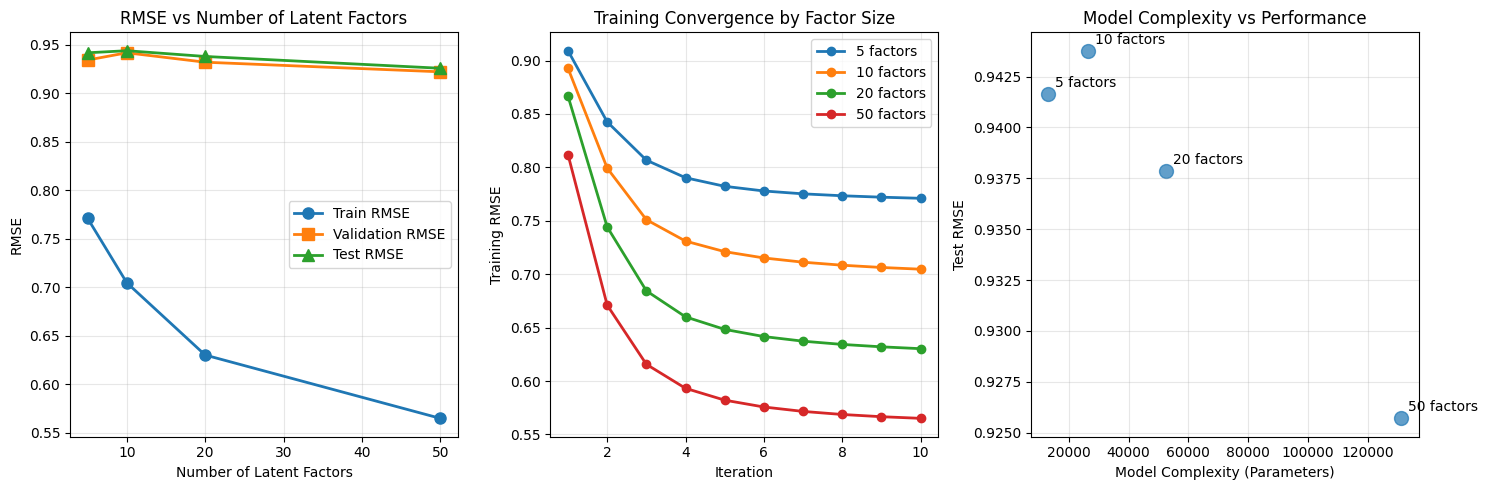


Best number of factors based on validation RMSE: 50

=== BONUS 2: TRAINING WITH EARLY STOPPING ===
Using 50 latent factors...
Starting training with 50 factors, λ=0.1
Iter  1: Train RMSE = 0.8118, Val RMSE = 0.9559
Iter  2: Train RMSE = 0.6721, Val RMSE = 0.9295
Iter  3: Train RMSE = 0.6161, Val RMSE = 0.9245
Iter  4: Train RMSE = 0.5935, Val RMSE = 0.9228
Iter  5: Train RMSE = 0.5823, Val RMSE = 0.9219
Iter  6: Train RMSE = 0.5759, Val RMSE = 0.9215
Iter  7: Train RMSE = 0.5718, Val RMSE = 0.9213
Iter  8: Train RMSE = 0.5691, Val RMSE = 0.9211
Iter  9: Train RMSE = 0.5671, Val RMSE = 0.9211
Iter 10: Train RMSE = 0.5656, Val RMSE = 0.9211
Iter 11: Train RMSE = 0.5645, Val RMSE = 0.9211
Iter 12: Train RMSE = 0.5636, Val RMSE = 0.9212
Early stopping at iteration 12

Final Test RMSE with early stopping: 0.9277


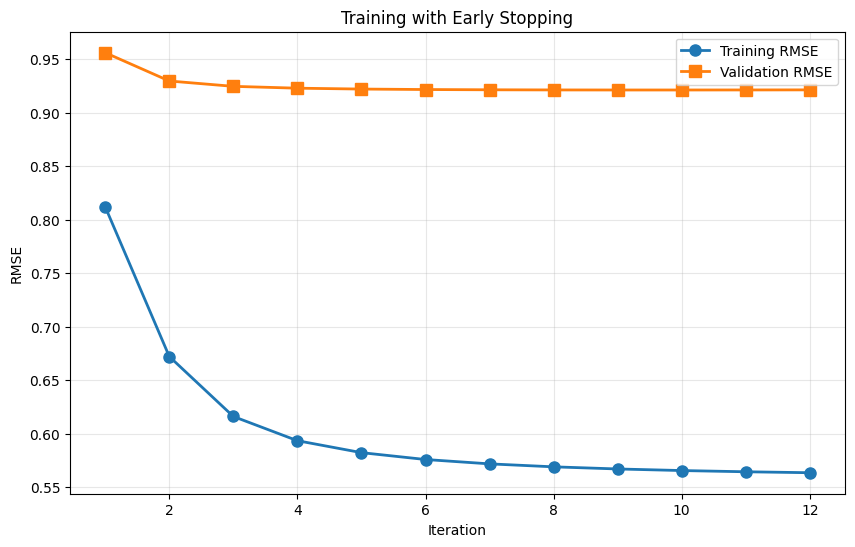


=== BONUS 3: VISUALIZING LATENT FACTORS WITH PCA ===
PCA explained variance ratio: [0.10192116 0.05221582]
Total variance explained: 0.154


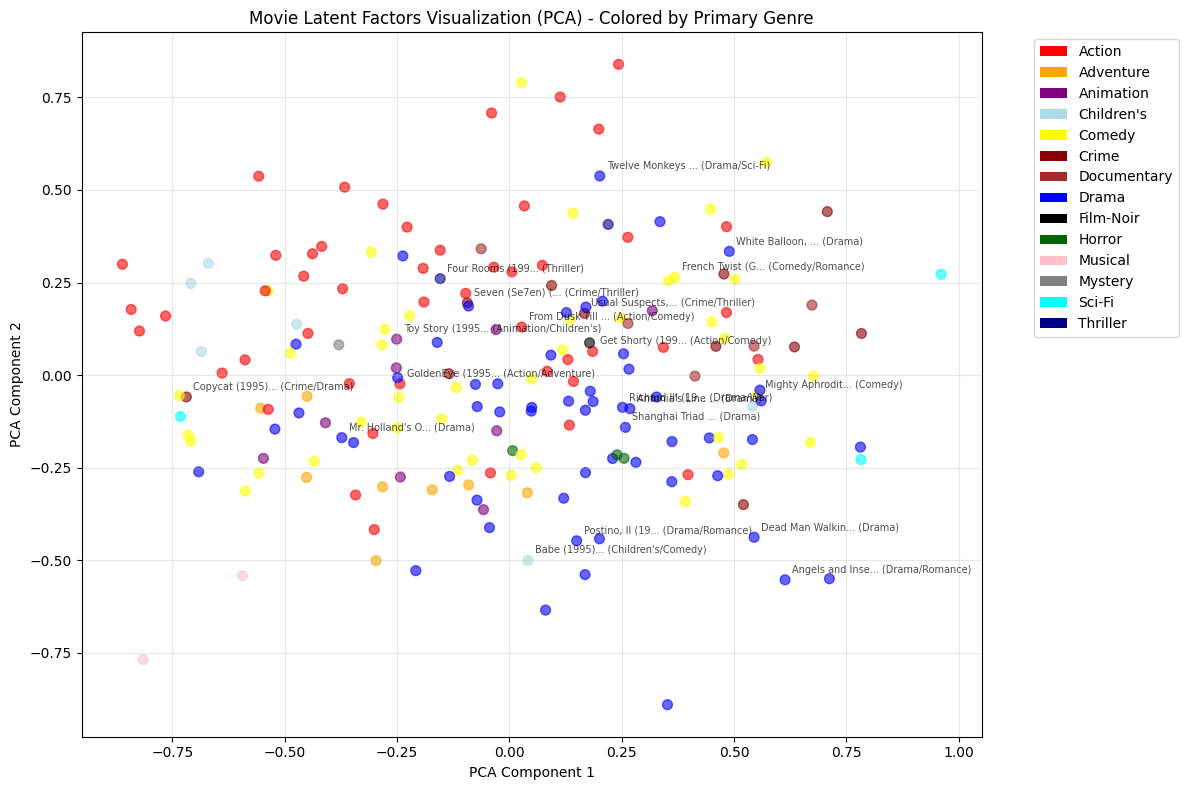


=== BONUS 3: VISUALIZING LATENT FACTORS WITH TSNE ===


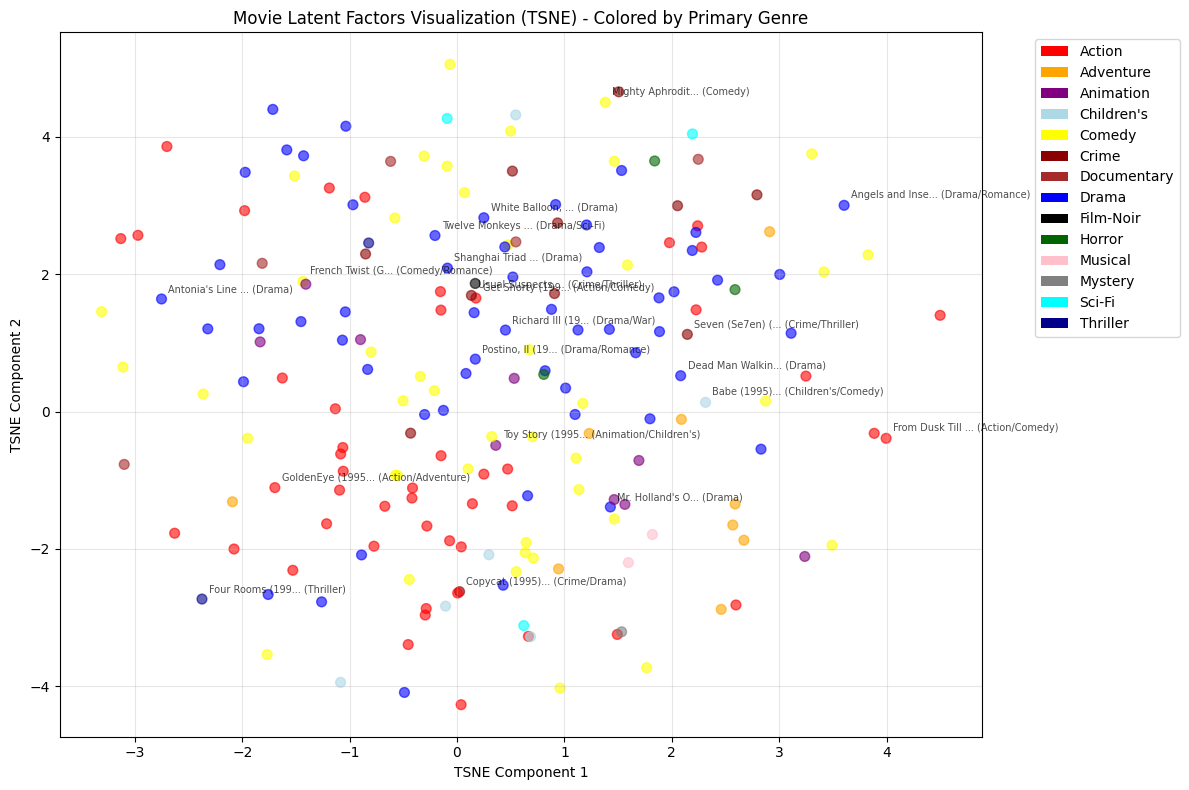


=== BONUS 4: ENHANCED RECOMMENDATIONS WITH DIVERSITY AND QUALITY EVALUATION ===

USER 50 ANALYSIS

EVALUATION: Regular Recommendations for User 50

Top 10 movies rated by user 50:
- Princess Bride, The (1987)                    (Rating: 5, Genres: Action, Adventure, Comedy, Romance)
- Return of the Jedi (1983)                     (Rating: 5, Genres: Action, Adventure, Romance, Sci-Fi, War)
- Much Ado About Nothing (1993)                 (Rating: 5, Genres: Comedy, Romance)
- Star Wars (1977)                              (Rating: 5, Genres: Action, Adventure, Romance, Sci-Fi, War)
- Empire Strikes Back, The (1980)               (Rating: 5, Genres: Action, Adventure, Drama, Romance, Sci-Fi, War)
- Die Hard (1988)                               (Rating: 5, Genres: Action, Thriller)
- Wizard of Oz, The (1939)                      (Rating: 4, Genres: Adventure, Children's, Drama, Musical)
- Shawshank Redemption, The (1994)              (Rating: 4, Genres: Drama)
- It's a Wonderful Life (194

In [10]:
# Main execution with all bonus features
if __name__ == "__main__":
    """
    MAIN EXECUTION: Complete pipeline demonstrating all implemented features

    This section orchestrates the entire recommendation system workflow:
    1. Load and split the MovieLens dataset
    2. Experiment with different latent factor dimensions (BONUS 1)
    3. Train final model with early stopping (BONUS 2)  
    4. Visualize learned latent factors using PCA and t-SNE (BONUS 3)
    5. Generate diverse recommendations and evaluate quality (BONUS 4)
    """
    print("=== ENHANCED Matrix Factorization with BONUS Features ===")

    # === DATA LOADING AND PREPROCESSING ===
    print("Loading data...")
    ratings = load_movielens_data()  # Load user-item-rating data
    movies = load_movie_titles()  # Load movie titles and genre information

    # Create proper train/validation/test split for robust evaluation
    # 60% train, 20% validation, 20% test
    # random_state ensures reproducibility
    train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

    # Display dataset statistics
    n_users = ratings['user_id'].nunique()
    n_items = ratings['item_id'].nunique()
    print(f"Number of users: {n_users}")
    print(f"Number of items: {n_items}")
    print(f"Number of ratings: {len(ratings)}")
    print(f"Training set size: {len(train_data)}")
    print(f"Validation set size: {len(val_data)}")
    print(f"Test set size: {len(test_data)}")

    # === BONUS 1: FACTOR SIZE EXPERIMENTS ===
    # Compare performance across different latent factor dimensions
    # This helps identify the optimal model complexity
    factor_results = experiment_with_factors(train_data, val_data, test_data, [5, 10, 20, 50])

    # Find optimal number of factors based on validation performance
    # This balances model complexity with generalization ability
    best_factors = min(factor_results.keys(),
                       key=lambda x: factor_results[x]['val_rmse'] if factor_results[x]['val_rmse'] else float('inf'))
    print(f"\nBest number of factors based on validation RMSE: {best_factors}")

    # === BONUS 2: FINAL MODEL WITH EARLY STOPPING ===
    print(f"\n=== BONUS 2: TRAINING WITH EARLY STOPPING ===")
    print(f"Using {best_factors} latent factors...")

    # Train final model with optimal hyperparameters and early stopping
    final_model = MatrixFactorization(n_users, n_items, n_factors=best_factors, regularization=0.1)
    train_errors, val_errors = final_model.fit_als(train_data, val_data, n_iterations=20,
                                                   early_stopping=True, patience=3)

    # Evaluate final model performance on held-out test set
    test_rmse = final_model.calculate_rmse(test_data)
    print(f"\nFinal Test RMSE with early stopping: {test_rmse:.4f}")

    # Visualize training process with early stopping
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_errors) + 1), train_errors, 'o-', label='Training RMSE', linewidth=2, markersize=8)
    plt.plot(range(1, len(val_errors) + 1), val_errors, 's-', label='Validation RMSE', linewidth=2, markersize=8)
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Training with Early Stopping')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('early_stopping.png', dpi=300, bbox_inches='tight')
    plt.show()

    # === BONUS 3: LATENT FACTOR VISUALIZATION ===
    # Visualize learned representations to understand what the model captured
    # PCA: Shows linear structure, preserves distances
    visualize_latent_factors(final_model, movies, method='pca', n_movies=200)

    # t-SNE: Shows local structure, better for finding clusters
    visualize_latent_factors(final_model, movies, method='tsne', n_movies=200)

    # === BONUS 4: ENHANCED RECOMMENDATIONS WITH DIVERSITY AND EVALUATION ===
    print("\n=== BONUS 4: ENHANCED RECOMMENDATIONS WITH DIVERSITY AND QUALITY EVALUATION ===")

    # Demonstrate recommendations for sample users
    # Users 50 and 100 chosen as examples - can be any valid user IDs
    for sample_user in [50, 100]:
        # Get items already rated by this user to exclude from recommendations
        user_ratings = ratings[ratings['user_id'] == sample_user]
        rated_items = user_ratings['item_id'].tolist()

        print(f"\n{'=' * 80}")
        print(f"USER {sample_user} ANALYSIS")
        print(f"{'=' * 80}")

        # Generate standard recommendations (highest predicted ratings)
        # This is the baseline approach - pure relevance
        regular_recs = final_model.get_user_recommendations(sample_user,
                                                            n_recommendations=10,
                                                            exclude_rated=True,
                                                            rated_items=rated_items,
                                                            ensure_diversity=False)

        # Generate diverse recommendations (genre variety + high ratings)
        # This balances relevance with content diversity
        diverse_recs = final_model.get_user_recommendations(sample_user,
                                                            n_recommendations=10,
                                                            exclude_rated=True,
                                                            rated_items=rated_items,
                                                            ensure_diversity=True,
                                                            movies_df=movies)

        # Evaluate regular recommendations
        # Shows genre alignment and quality metrics
        evaluate_user_recommendations(sample_user, ratings, movies, final_model,
                                      regular_recs, "Regular", n_recommendations=10)

        # Evaluate diverse recommendations
        # Compare how diversity affects genre alignment
        evaluate_user_recommendations(sample_user, ratings, movies, final_model,
                                      diverse_recs, "Diverse", n_recommendations=10)

    # === FINAL EVALUATION SUMMARY ===
    print(f"\n{'=' * 80}")
    print(f"FINAL EVALUATION SUMMARY")
    print(f"{'=' * 80}")
    print(f"Best number of latent factors: {best_factors}")
    print(f"Training RMSE (final): {train_errors[-1]:.4f}")
    print(f"Validation RMSE (final): {val_errors[-1]:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")